In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from abc import ABC, abstractmethod
from tqdm import tqdm
from itertools import product

from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking


from constants import ROOT_DIR

# Modeling

In [2]:
DATA_DIR = ROOT_DIR / "data"
CLICKS_DIR = DATA_DIR / "unzip_clicks"
WORK_DIR = DATA_DIR / "workbase"

# Select the split date for training and testing
SPLIT_DATE = pd.to_datetime("2017-10-10")
# Load the train & test splits with the test_df_09.pickle and test_df_10.pickle
train_data = (
    pd.read_pickle(WORK_DIR / "train_filtered_10.pickle")
    .sort_values("click_timestamp", ascending=True)
    .reset_index(drop=True)
    .astype(
        {
            "article_id": "int32",
            "category_id": "int32",
            "publisher_id": "int32",
            "words_count": "int32",
        }
    )
)
test_data = (
    pd.read_pickle(WORK_DIR / "test_filtered_10.pickle")
    .sort_values("click_timestamp", ascending=True)
    .reset_index(drop=True)
    .astype(
        {
            "article_id": "int32",
            "category_id": "int32",
            "publisher_id": "int32",
            "words_count": "int32",
        }
    )
)

# Load embeddings_df
embeddings = pd.read_pickle(WORK_DIR / "articles_embeddings.pickle")

In [3]:
class Recommender(ABC):
    """
    Abstract base class for recommender systems that provides a common interface.
    Choose a value for k to define the number of recommendations to return and to evaluate, as metric@k.
    """

    def __init__(self, k: int, train_data: pd.DataFrame):
        self.k = k
        self.train_data = train_data

    @abstractmethod
    def fit_transform(self, test_data: pd.DataFrame):
        """
        Fit the recommender model to the training data.

        Args:
            data (pd.DataFrame): The training data.
        """
        pass

    @abstractmethod
    def recommend(self, user_id: int) -> list[int]:
        """
        Recommend items for a given user.

        Args:
            user_id (int): The ID of the user to recommend items for.
        Returns:
            list[int]: A list of recommended item IDs.
        """
        pass

    def evaluate(self, test_data: pd.DataFrame) -> float:
        """
        Evaluate the recommender model on the test data.

        Args:
            test_data (pd.DataFrame): The test data containing user-item interactions.
        Returns:
            float: The evaluation metric score (e.g., precision, recall, etc.).
        """
        # Fit the model and transform the test data
        self.fit_transform(test_data)

        # Instantiate lists to store evaluation metrics
        hits, precisions, recalls, f1s = [], [], [], []

        # Iterate over each user in the test data
        for user_id in tqdm(test_data["user_id"].unique()):
            true_items = set(
                test_data.loc[
                    test_data["user_id"] == user_id, "click_article_id"
                ].unique()
            )
            # If a user has no true items, skip evaluation for this user
            if not true_items:
                continue

            recommended_items = self.recommend(user_id)
            top_k = set(recommended_items[: self.k])
            n_hit = len(true_items & top_k)

            hit = 1.0 if n_hit > 0 else 0.0
            precision = n_hit / len(top_k)
            recall = n_hit / len(true_items)
            f1 = (
                2 * precision * recall / (precision + recall)
                if precision + recall > 0
                else 0.0
            )

            hits.append(hit)
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)

        return {
            f"Hit@{self.k}": np.mean(hits).round(4),
            f"Precision@{self.k}": np.mean(precisions).round(4),
            f"Recall@{self.k}": np.mean(recalls).round(4),
            f"F1@{self.k}": np.mean(f1s).round(4),
        }

## Baseline model : popularity-based recommender

In [4]:
class PopularityRecommender(Recommender):
    """
    Recommender system that recommends items based on their popularity.
    """

    def __init__(self, k: int, train_data: pd.DataFrame):
        super().__init__(k, train_data)
        self.train_article_popularity = None
        self.train_category_popularity = None
        self.article_popularity = None

    def fit_transform(self, test_data: pd.DataFrame):
        """
        Fit the recommender model to the training data by calculating item popularity.
        """
        self.train_article_popularity = (
            self.train_data["click_article_id"].value_counts(normalize=True).to_dict()
        )
        self.train_category_popularity = (
            self.train_data["category_id"].value_counts(normalize=True).to_dict()
        )

        # Create a Series with article popularity for test articles
        test_article_popularity = (
            test_data["click_article_id"]
            .drop_duplicates()
            .map(lambda x: self.train_article_popularity.get(x, np.nan))
        )

        # Fill NaN values with category popularity (using the article's category)
        article_to_category = test_data.drop_duplicates("click_article_id").set_index(
            "click_article_id"
        )["category_id"]
        test_article_popularity = test_article_popularity.fillna(
            article_to_category.map(self.train_category_popularity)
        ).to_dict()
        # Create a Series with article popularity from both train and test data
        self.article_popularity = pd.Series(
            {**self.train_article_popularity, **test_article_popularity}
        ).sort_values(ascending=False)

    def recommend(self, user_id: int) -> list[int]:
        """
        Recommend items for a given user based on item popularity.
        """
        if self.article_popularity is None:
            raise ValueError("Model has not been fitted yet.")

        try:
            read_articles = set(
                self.train_data.loc[
                    self.train_data["user_id"] == user_id, "click_article_id"
                ].unique()
            )
        except KeyError:
            print(f"User ID {user_id} not found in the training data.")

        # Get the article popularity
        articles_not_read = self.article_popularity[
            ~self.article_popularity.index.isin(read_articles)
        ]
        # Filter out the articles already read by the user
        recommendations = articles_not_read.head(self.k)
        # Return the top N recommendations
        return recommendations.index.tolist()

In [5]:
# Evaluate the recommender
recommender = PopularityRecommender(k=5, train_data=train_data)
scores = recommender.evaluate(test_data)
print(scores)

  0%|          | 0/10195 [00:00<?, ?it/s]

100%|██████████| 10195/10195 [00:06<00:00, 1698.59it/s]

{'Hit@5': np.float64(0.0511), 'Precision@5': np.float64(0.0102), 'Recall@5': np.float64(0.0039), 'F1@5': np.float64(0.0054)}


In [6]:
# Test the recommender with a specific user ID
recommender.recommend(59)

[160974, 114321, 29953, 56041, 123909]

# Content based recommender system

In [7]:
class ContentBasedRecommender(Recommender):
    """
    Recommender system that recommends items based on content similarity.
    """

    def __init__(
        self,
        k: int,
        train_data: pd.DataFrame,
        embeddings: np.ndarray,
    ):
        super().__init__(k, train_data)
        self.embeddings = embeddings
        self.valid_articles_ids = None

    def get_valid_articles_ids(self, test_data: pd.DataFrame) -> set[int]:
        """
        Get the set of valid article IDs that can be recommended.
        Returns:
            set[int]: A set of valid article IDs.
        """
        return set(self.train_data["click_article_id"].unique()) | set(
            test_data["click_article_id"].unique()
        )

    def fit_transform(self, test_data: pd.DataFrame) -> None:
        """
        Fit the recommender model to the training data by loading embeddings.
        """
        self.embeddings = pd.DataFrame(self.embeddings)
        self.embeddings.index.name = "click_article_id"
        # Filter the embeddings to only include articles present in the train and test data
        self.valid_articles_ids = self.get_valid_articles_ids(test_data)
        self.embeddings = self.embeddings.loc[
            self.embeddings.index.intersection(self.valid_articles_ids), :
        ]

    def build_user_profile(self, user_id: int, read_articles: set[int]) -> pd.Series:
        """
        Build a user profile based on the embeddings of articles read by the user.
        """
        if self.embeddings is None:
            raise ValueError("Model has not been fitted yet.")

        # Get the embeddings of articles read by the user
        read_embeddings = self.embeddings.loc[list(read_articles)]

        # Calculate the mean embedding for the user's read articles
        user_profile = read_embeddings.mean(axis=0)

        return user_profile

    def recommend(self, user_id: int) -> list[int]:
        """
        Recommend items for a given user based on content similarity.
        """
        if self.valid_articles_ids is None:
            raise ValueError("Model has not been fitted yet.")

        read_articles = set(
            self.train_data.loc[
                self.train_data["user_id"] == user_id, "click_article_id"
            ].unique()
        )

        # Get the embeddings of articles not read by the user
        articles_not_read = self.embeddings[~self.embeddings.index.isin(read_articles)]

        # Calculate similarity scores with the mean embedding of read articles
        scores = articles_not_read.dot(self.build_user_profile(user_id, read_articles))

        # Get the top N recommendations based on scores
        recommendations = scores.nlargest(self.k)

        return recommendations.index.tolist()

In [8]:
# Evaluate the recommender
recommender = ContentBasedRecommender(k=5, train_data=train_data, embeddings=embeddings)
scores = recommender.evaluate(test_data)
print(scores)

100%|██████████| 10195/10195 [00:27<00:00, 372.81it/s]

{'Hit@5': np.float64(0.0679), 'Precision@5': np.float64(0.0158), 'Recall@5': np.float64(0.0064), 'F1@5': np.float64(0.0087)}


In [9]:
# Test the recommender with a specific user ID
recommender.recommend(59)

[235443, 235961, 237452, 236988, 234128]

In [10]:
class WeightedContentBasedRecommender(ContentBasedRecommender):
    """
    Recommender system that recommends items based on content similarity with user preferences weighted according to article categories, recency and click position.
    """

    def __init__(
        self,
        k: int,
        train_data: pd.DataFrame,
        split_date: datetime,
        embeddings: np.ndarray,
        w_recency: float = None,
        w_position: float = None,
        w_category: bool = True,
    ):
        super().__init__(k, train_data, embeddings)
        self.w_recency = w_recency
        self.w_position = w_position
        self.split_date = split_date
        self.w_category = w_category
        self.w_user_category = None

    def recency_weight(self, date_str):
        delta = (self.split_date - date_str).days
        return np.exp(-self.w_recency * delta)

    def ranking_weight(self, position):
        return np.exp(-self.w_position * (position - 1))

    def build_user_profile(self, user_id: int, read_articles: set[int]) -> pd.Series:
        """
        Build a user profile based on the embeddings of articles read by the user.
        """
        if self.embeddings is None:
            raise ValueError("Model has not been fitted yet.")

        # Build the weighted user profile
        weighted_embeddings = []
        # Get the DataFrame of articles read by the user
        user_df = self.train_data.loc[
            self.train_data["user_id"] == user_id,
            ["click_article_id", "click_timestamp", "click_ranking", "category_id"],
        ]
        self.w_user_category = (
            user_df["category_id"].value_counts(normalize=True).to_dict()
        )

        # Iterate through each read article to calculate the weighted embedding
        for row in user_df.itertuples():
            article_id = row.click_article_id
            # Get the embedding for the article
            embedding = self.embeddings.loc[article_id]

            # Calculate weights
            recency_weight = self.recency_weight(row.click_timestamp)
            ranking_weight = self.ranking_weight(row.click_ranking)
            category_weight = self.w_user_category.get(
                row.category_id, 1.0 / sum(self.w_user_category.values())
            )

            # Combine weights
            weight = (
                recency_weight * ranking_weight * category_weight
                if self.w_category
                else recency_weight * ranking_weight
            )

            # Append weighted embedding
            weighted_embeddings.append(embedding * weight)

        user_profile = (
            sum(weighted_embeddings) / len(weighted_embeddings)
            if weighted_embeddings
            else pd.Series(dtype=float)
        )

        return user_profile

In [11]:
# Evaluate the recommender
all_scores = []
w_recency_values = [0.15, 0.25, 0.35, 0.45]
w_position_values = [0.25, 0.5, 0.75]
w_category_values = [True, False]

for w_recency, w_position, w_category in tqdm(
    product(w_recency_values, w_position_values, w_category_values)
):
    recommender = WeightedContentBasedRecommender(
        k=5,
        train_data=train_data,
        embeddings=embeddings,
        w_recency=w_recency,
        w_position=w_position,
        w_category=w_category,
        split_date=SPLIT_DATE,
    )
    scores = recommender.evaluate(test_data)
    all_scores.append(scores)

100%|██████████| 10195/10195 [01:15<00:00, 134.18it/s]
24it [30:09, 75.38s/it]


In [ ]:
param_grid = pd.DataFrame(
    product(w_recency_values, w_position_values, w_category_values),
    columns=["w_recency", "w_position", "w_category"],
)
scores_df = pd.DataFrame(all_scores)
result_df = pd.concat([param_grid, scores_df], axis=1)
result_df = (
    result_df.sort_values(by=["w_recency", "w_position", "w_category"])
    .reset_index(drop=True)
    .round(4)
)

,w_recency,w_position,w_category,Hit@5,Precision@5,Recall@5,F1@5
0,0.15,0.25,False,0.0707,0.0164,0.0067,0.0090
1,0.15,0.25,True,0.0718,0.0171,0.0070,0.0094
2,0.15,0.50,False,0.0705,0.0162,0.0067,0.0089
3,0.15,0.50,True,0.0721,0.0171,0.0070,0.0094
4,0.15,0.75,False,0.0726,0.0168,0.0069,0.0092
5,0.15,0.75,True,0.0725,0.0173,0.0070,0.0094
6,0.25,0.25,False,0.0727,0.0168,0.0069,0.0092
7,0.25,0.25,True,0.0733,0.0175,0.0072,0.0096
8,0.25,0.50,False,0.0741,0.0170,0.0070,0.0094
9,0.25,0.50,True,0.0734,0.0173,0.0071,0.0095


In [13]:
# Test the recommender with a specific user ID
recommender.recommend(59)

[108857, 108853, 108854, 108908, 108855]

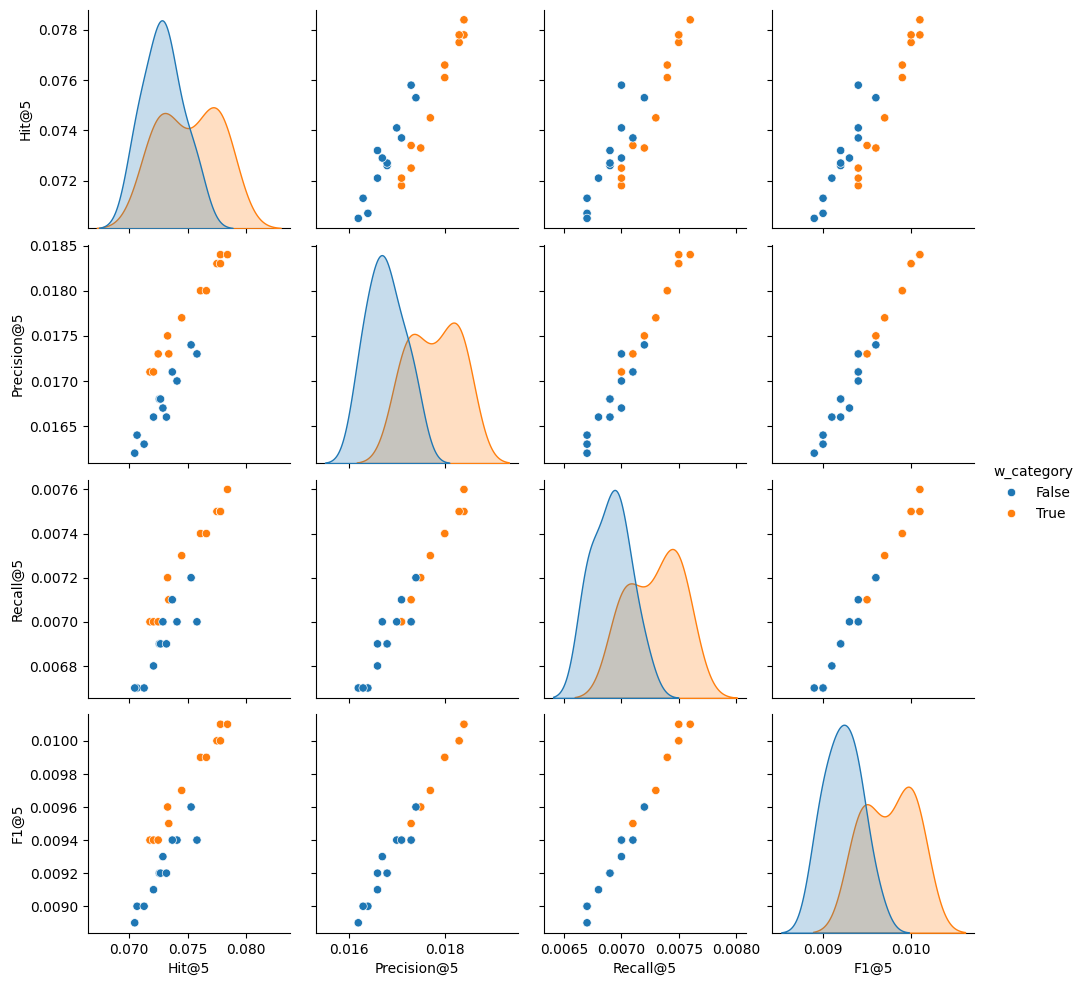

In [16]:
sns.pairplot(
    result_df,
    diag_kind="kde",
    hue="w_category",
    vars=["Hit@5", "Precision@5", "Recall@5", "F1@5"],
)

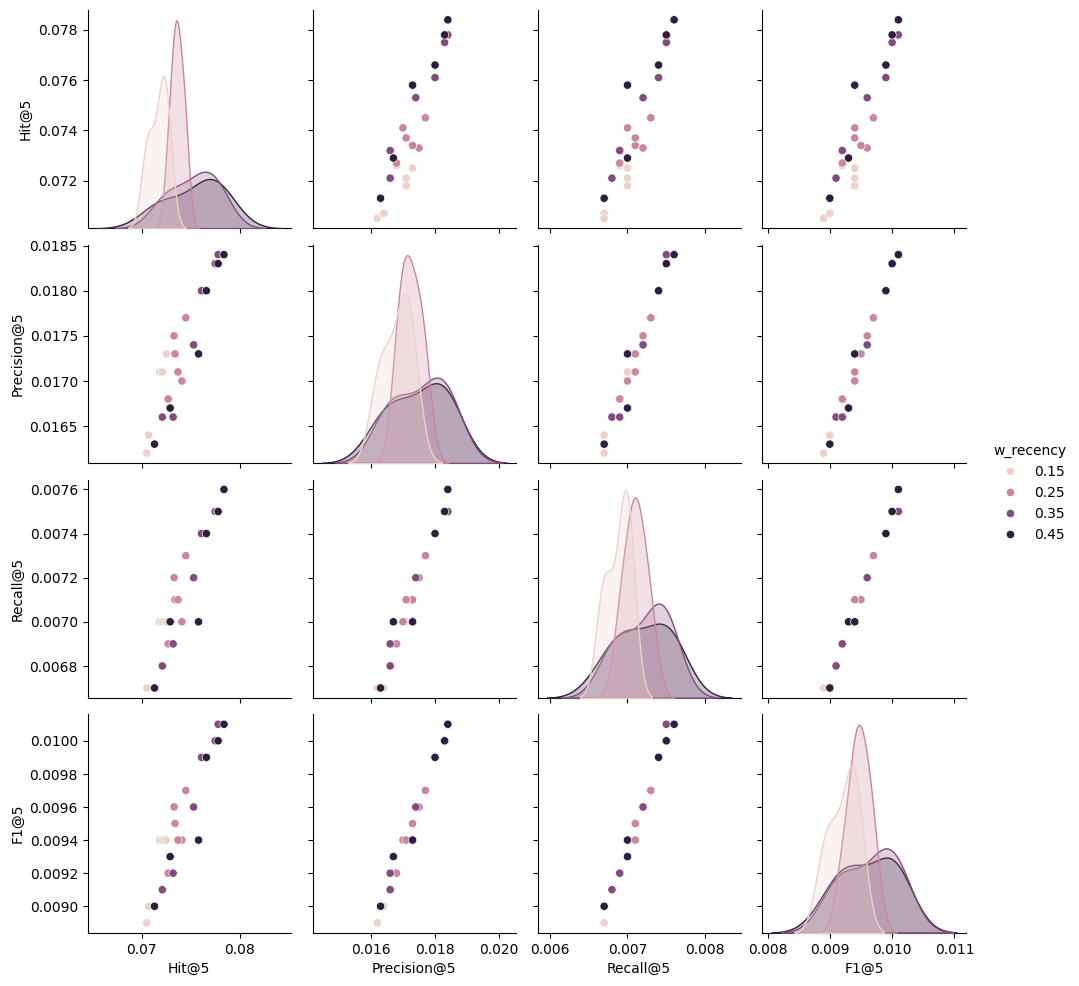

In [17]:
sns.pairplot(
    result_df,
    diag_kind="kde",
    hue="w_recency",
    vars=["Hit@5", "Precision@5", "Recall@5", "F1@5"],
)

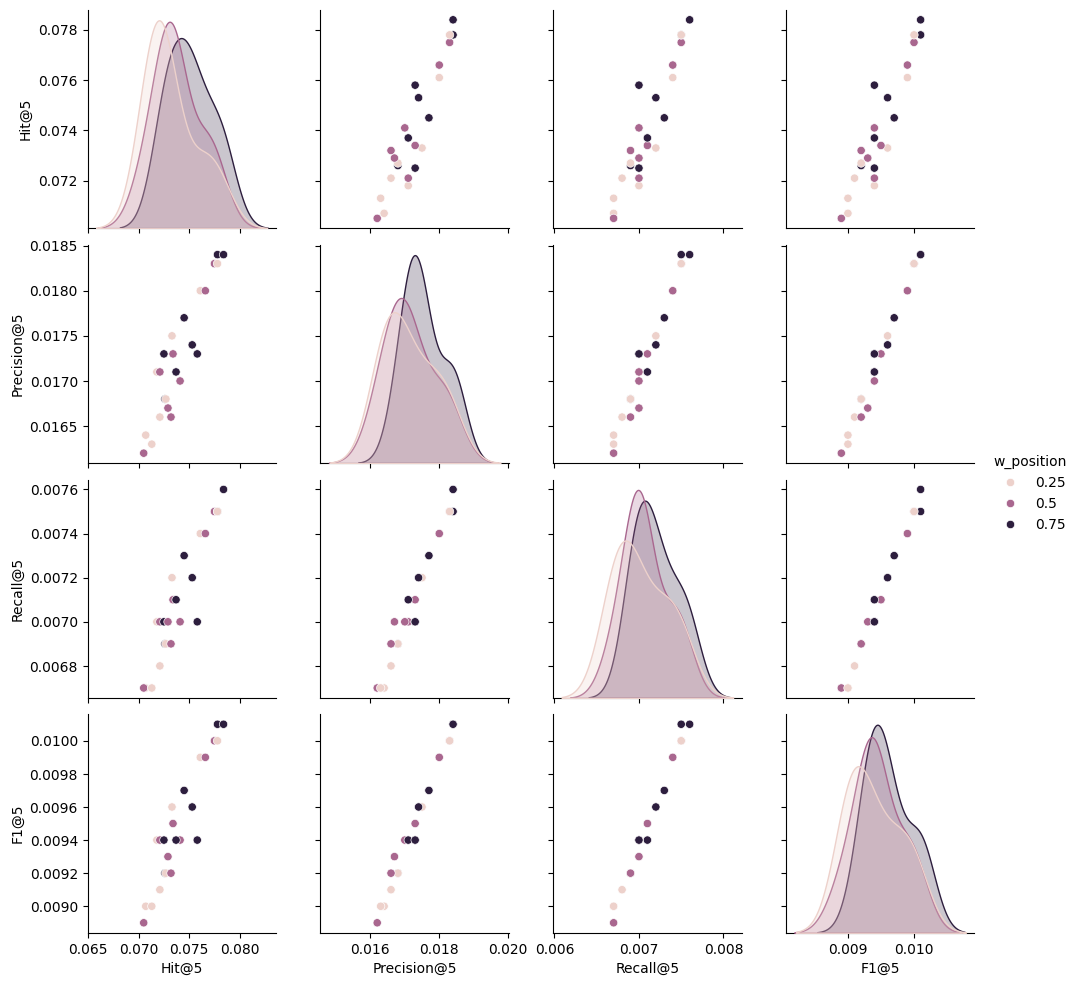

In [18]:
sns.pairplot(
    result_df,
    diag_kind="kde",
    hue="w_position",
    vars=["Hit@5", "Precision@5", "Recall@5", "F1@5"],
)

# Collaborative filtering recommender system
```

- Problème de l'approche collaborative filtering : les articles qui n'ont pas été vus dans le jeu d'entraînement ne seront pas recommandés.
- Taux de renouvellement des articles réguliers peu adaptés au collaborative filtering.

In [4]:
class CollaborativeFilteringRecommender(Recommender):
    def __init__(self, k: int, train_data: pd.DataFrame, model):
        """
        Args:
            k (int): Number of recommendations to return.
            train_data (pd.DataFrame): Training data.
            model: Any fitted implicit model instance (e.g., AlternatingLeastSquares, BayesianPersonalizedRanking, etc.).
        """
        super().__init__(k, train_data)
        self.model = model
        self.user_id_map = {}
        self.click_article_id_map = {}
        self.inv_click_article_id_map = {}
        self.user_items_matrix: csr_matrix = None

    def build_mapping(self) -> None:
        """Create mappings for user and item IDs to integer indices."""
        self.user_id_map = {
            user_id: i for i, user_id in enumerate(self.train_data["user_id"].unique())
        }
        self.click_article_id_map = {
            item_id: i
            for i, item_id in enumerate(self.train_data["click_article_id"].unique())
        }
        self.inv_click_article_id_map = {
            i: item_id for item_id, i in self.click_article_id_map.items()
        }

    def build_user_item_matrix(self) -> None:
        """Create a sparse user-item matrix weighted by inverse click rank."""
        if not self.user_id_map or not self.click_article_id_map:
            self.build_mapping()
        rows = self.train_data["user_id"].map(self.user_id_map)
        cols = self.train_data["click_article_id"].map(self.click_article_id_map)

        # Poids : score inverse (plus proche de 1 = mieux)
        weights = 1 / self.train_data["click_ranking"].astype(float).values

        matrix = csr_matrix(
            (weights, (rows, cols)),
        )

        return matrix

    def fit_transform(self, test_data: pd.DataFrame) -> None:
        """Encode user and item ids to integer indices for the matrix."""
        self.user_items_matrix = self.build_user_item_matrix()
        self.model.fit(self.user_items_matrix)

    def recommend(self, user_id: int) -> list[int]:
        if self.user_items_matrix is None:
            raise ValueError("Model has not been fitted yet.")
        user_index = self.user_id_map.get(user_id)
        user_items = self.user_items_matrix[user_index]

        recommended, scores = self.model.recommend(
            user_index, user_items, N=self.k, filter_already_liked_items=True
        )

        return [self.inv_click_article_id_map[i] for i in recommended]


In [11]:
for factors in [5, 10, 20, 50, 100]:
    # Create and fit the ALS model
    model = AlternatingLeastSquares(factors=factors, regularization=0.01, iterations=20)
    # Evaluate the recommender
    recommender = CollaborativeFilteringRecommender(
        k=5, train_data=train_data, model=model
    )
    scores = recommender.evaluate(test_data)
    print(scores)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 10195/10195 [00:03<00:00, 2924.82it/s]

{'Hit@5': np.float64(0.0309), 'Precision@5': np.float64(0.0063), 'Recall@5': np.float64(0.0024), 'F1@5': np.float64(0.0033)}


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 10195/10195 [00:03<00:00, 2945.32it/s]

{'Hit@5': np.float64(0.0331), 'Precision@5': np.float64(0.0069), 'Recall@5': np.float64(0.0027), 'F1@5': np.float64(0.0037)}


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 10195/10195 [00:01<00:00, 9381.85it/s]

{'Hit@5': np.float64(0.0171), 'Precision@5': np.float64(0.0035), 'Recall@5': np.float64(0.0014), 'F1@5': np.float64(0.0018)}


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 10195/10195 [00:03<00:00, 3041.76it/s]

{'Hit@5': np.float64(0.0131), 'Precision@5': np.float64(0.0027), 'Recall@5': np.float64(0.0011), 'F1@5': np.float64(0.0014)}


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 10195/10195 [00:03<00:00, 2931.20it/s]

{'Hit@5': np.float64(0.0031), 'Precision@5': np.float64(0.0007), 'Recall@5': np.float64(0.0003), 'F1@5': np.float64(0.0004)}


In [10]:
for factors in [100, 250, 500, 1000]:
    model = BayesianPersonalizedRanking(
        factors=factors, learning_rate=0.05, regularization=0.01, iterations=50
    )
    # Evaluate the recommender
    recommender = CollaborativeFilteringRecommender(
        k=5, train_data=train_data, model=model
    )
    scores = recommender.evaluate(test_data)
    print(scores)


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 10195/10195 [00:01<00:00, 6307.04it/s]

{'Hit@5': np.float64(0.0081), 'Precision@5': np.float64(0.0018), 'Recall@5': np.float64(0.0007), 'F1@5': np.float64(0.0009)}


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 10195/10195 [00:05<00:00, 1854.66it/s]


{'Hit@5': np.float64(0.008), 'Precision@5': np.float64(0.0017), 'Recall@5': np.float64(0.0006), 'F1@5': np.float64(0.0009)}


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 10195/10195 [00:06<00:00, 1695.13it/s]


{'Hit@5': np.float64(0.0075), 'Precision@5': np.float64(0.0016), 'Recall@5': np.float64(0.0006), 'F1@5': np.float64(0.0009)}


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 10195/10195 [00:06<00:00, 1655.95it/s]

{'Hit@5': np.float64(0.0077), 'Precision@5': np.float64(0.0016), 'Recall@5': np.float64(0.0007), 'F1@5': np.float64(0.0009)}


# Hybrid Recommender System

Cette approche hybride combine :
- **Collaborative Filtering** : pour les articles présents dans le jeu d'entraînement (articles avec historique d'interactions)
- **Content-Based avec pondérations** : pour les nouveaux articles (cold start) en utilisant la similarité cosinus avec les pondérations de récence, position et catégorie

Avantages :
- Résout le problème de cold start pour les nouveaux articles
- Utilise les préférences collaboratives quand c'est possible
- Maintient la personnalisation avec les pondérations content-based

In [13]:
from sklearn.metrics.pairwise import cosine_similarity


class HybridRecommender(Recommender):
    """
    Système de recommandation hybride qui combine :
    - Collaborative Filtering pour les articles vus dans l'entraînement
    - Content-Based pondéré pour les nouveaux articles (cold start)
    """

    def __init__(
        self,
        k: int,
        train_data: pd.DataFrame,
        embeddings: np.ndarray,
        cf_model,
        split_date: datetime,
        w_recency: float = 0.25,
        w_position: float = 0.5,
        w_category: bool = True,
        use_ranking_weights: bool = True,
    ):
        """
        Args:
            k (int): Nombre de recommandations à retourner
            train_data (pd.DataFrame): Données d'entraînement
            embeddings (np.ndarray): Embeddings des articles
            cf_model: Modèle de collaborative filtering (ALS, BPR, etc.)
            split_date (datetime): Date de séparation pour les pondérations de récence
            w_recency (float): Poids pour la récence
            w_position (float): Poids pour la position de clic
            w_category (bool): Utiliser les pondérations de catégorie
            use_ranking_weights (bool): Utiliser les poids de ranking pour CF
        """
        super().__init__(k, train_data)
        self.embeddings = embeddings
        self.cf_model = cf_model
        self.split_date = split_date
        self.w_recency = w_recency
        self.w_position = w_position
        self.w_category = w_category
        self.use_ranking_weights = use_ranking_weights

        # Composants pour collaborative filtering
        self.cf_recommender = None

        # Composants pour content-based
        self.embeddings_df = None
        self.valid_articles_ids = None
        self.train_articles = None
        self.test_articles = None

    def fit_transform(self, test_data: pd.DataFrame) -> None:
        """
        Prépare les deux systèmes de recommandation.
        """
        # Initialiser le collaborative filtering
        self.cf_recommender = CollaborativeFilteringRecommender(
            k=self.k, train_data=self.train_data, model=self.cf_model
        )
        self.cf_recommender.fit_transform(test_data)

        # Préparer les embeddings pour content-based
        self.embeddings_df = pd.DataFrame(self.embeddings)
        self.embeddings_df.index.name = "click_article_id"

        # Identifier les articles d'entraînement et de test
        self.train_articles = set(self.train_data["click_article_id"].unique())
        self.test_articles = set(test_data["click_article_id"].unique())
        self.valid_articles_ids = self.train_articles | self.test_articles

        # Filtrer les embeddings
        self.embeddings_df = self.embeddings_df.loc[
            self.embeddings_df.index.intersection(self.valid_articles_ids), :
        ]

    def build_weighted_user_profile(
        self, user_id: int, read_articles: set[int]
    ) -> pd.Series:
        """
        Construit un profil utilisateur pondéré basé sur les embeddings des articles lus.
        """
        if self.embeddings_df is None:
            raise ValueError("Model has not been fitted yet.")

        weighted_embeddings = []
        user_df = self.train_data.loc[
            self.train_data["user_id"] == user_id,
            ["click_article_id", "click_timestamp", "click_ranking", "category_id"],
        ]

        # Calculer les pondérations par catégorie
        w_user_category = user_df["category_id"].value_counts(normalize=True).to_dict()

        for row in user_df.itertuples():
            article_id = row.click_article_id
            if article_id not in self.embeddings_df.index:
                continue

            embedding = self.embeddings_df.loc[article_id]

            # Calculer les poids
            recency_weight = self._recency_weight(row.click_timestamp)
            ranking_weight = self._ranking_weight(row.click_ranking)
            category_weight = w_user_category.get(
                row.category_id, 1.0 / len(w_user_category)
            )

            # Combiner les poids
            if self.w_category:
                weight = recency_weight * ranking_weight * category_weight
            else:
                weight = recency_weight * ranking_weight

            weighted_embeddings.append(embedding * weight)

        if weighted_embeddings:
            user_profile = sum(weighted_embeddings) / len(weighted_embeddings)
        else:
            # Profil par défaut si aucun article n'a d'embedding
            user_profile = pd.Series(0, index=self.embeddings_df.columns)

        return user_profile

    def _recency_weight(self, date_str):
        """Calcule le poids de récence."""
        delta = (self.split_date - date_str).days
        return np.exp(-self.w_recency * delta)

    def _ranking_weight(self, position):
        """Calcule le poids de position de clic."""
        return np.exp(-self.w_position * (position - 1))

    def get_cf_recommendations(self, user_id: int) -> list[int]:
        """
        Obtient les recommandations du collaborative filtering.
        """
        try:
            return self.cf_recommender.recommend(user_id)
        except (KeyError, ValueError):
            # Utilisateur pas dans les données d'entraînement
            return []

    def get_content_recommendations(
        self, user_id: int, articles_to_score: set[int]
    ) -> list[int]:
        """
        Obtient les recommandations content-based pour les articles spécifiés.
        """
        read_articles = set(
            self.train_data.loc[
                self.train_data["user_id"] == user_id, "click_article_id"
            ].unique()
        )

        if not read_articles:
            # Utilisateur sans historique - recommandations par popularité
            return []

        # Construire le profil utilisateur pondéré
        user_profile = self.build_weighted_user_profile(user_id, read_articles)

        # Filtrer les articles à scorer
        available_articles = articles_to_score & set(self.embeddings_df.index)
        if not available_articles:
            return []

        articles_embeddings = self.embeddings_df.loc[list(available_articles)]

        # Calculer la similarité cosinus
        user_profile_2d = user_profile.values.reshape(1, -1)
        similarities = cosine_similarity(user_profile_2d, articles_embeddings.values)[0]

        # Créer un DataFrame avec les scores
        scores_df = pd.DataFrame(
            {"article_id": articles_embeddings.index, "score": similarities}
        ).sort_values("score", ascending=False)

        return scores_df["article_id"].head(self.k).tolist()

    def recommend(self, user_id: int) -> list[int]:
        """
        Recommande des articles en utilisant l'approche hybride.
        """
        if self.cf_recommender is None or self.embeddings_df is None:
            raise ValueError("Model has not been fitted yet.")

        read_articles = set(
            self.train_data.loc[
                self.train_data["user_id"] == user_id, "click_article_id"
            ].unique()
        )

        # 1. Essayer d'abord le collaborative filtering
        cf_recommendations = self.get_cf_recommendations(user_id)

        # Articles disponibles pour recommandation (non lus)
        available_articles = self.valid_articles_ids - read_articles

        # 2. Séparer les articles selon leur présence dans l'entraînement
        cf_available = [art for art in cf_recommendations if art in available_articles]

        # Articles nouveaux (pas dans l'entraînement) disponibles
        new_articles = available_articles - self.train_articles

        # 3. Compléter avec content-based pour les nouveaux articles si nécessaire
        content_recommendations = []
        if len(cf_available) < self.k and new_articles:
            remaining_slots = self.k - len(cf_available)
            content_recommendations = self.get_content_recommendations(
                user_id, new_articles
            )[:remaining_slots]

        # 4. Combiner les recommandations
        final_recommendations = cf_available + content_recommendations

        # 5. Si pas assez de recommandations, compléter avec content-based sur tous les articles
        if len(final_recommendations) < self.k:
            remaining_slots = self.k - len(final_recommendations)
            already_recommended = set(final_recommendations)
            remaining_articles = available_articles - already_recommended

            if remaining_articles:
                additional_content = self.get_content_recommendations(
                    user_id, remaining_articles
                )[:remaining_slots]
                final_recommendations.extend(additional_content)

        return final_recommendations[: self.k]

In [14]:
# Test et évaluation du recommandeur hybride

# Créer un modèle ALS pour le collaborative filtering
cf_model = AlternatingLeastSquares(factors=10, regularization=0.01, iterations=20)

# Créer le recommandeur hybride
hybrid_recommender = HybridRecommender(
    k=5,
    train_data=train_data,
    embeddings=embeddings,
    cf_model=cf_model,
    split_date=SPLIT_DATE,
    w_recency=0.25,
    w_position=0.5,
    w_category=True,
    use_ranking_weights=True,
)

# Évaluer le recommandeur
print("Évaluation du recommandeur hybride:")
hybrid_scores = hybrid_recommender.evaluate(test_data)
print(hybrid_scores)

Évaluation du recommandeur hybride:


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 10195/10195 [00:08<00:00, 1231.20it/s]

{'Hit@5': np.float64(0.0311), 'Precision@5': np.float64(0.0065), 'Recall@5': np.float64(0.0025), 'F1@5': np.float64(0.0034)}
